# Development 3D MRI Segmentation

Development of Image Segmentation Methods based on UBNet-Seg for Segmentation on Multiresolution 3D Brain MRI

## Setting Enviroment and Library

In [5]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns

!pip install --upgrade matplotlib==3.3.0
import matplotlib.pyplot as plt

#Library untuk olah citra
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage. transform import rotate, resize
from PIL import Image, ImageOps


#Library untuk visualisasi citra MRI
!pip install nibabel==3.2
import nibabel as nib

#Library Deep Learning
import keras
import keras.backend as K
from keras.callbacks import CSVLogger

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#Opsional, setting standar penulisan angka
np.set_printoptions(precision=3, suppress=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 71.1 MB/s eta 0:00:00
  Attempting uninstall: nibabel
    Found existing installation: nibabel 3.0.2
    Uninstalling nibabel-3.0.2:
      Successfully uninstalled nibabel-3.0.2


In [ ]:
#!pip freeze > requirements.txt

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
#Mendefinisikan kelas dan parameter segmentasi MRI

SEGMENT_CLASSES = {
    0 : 'Bukan Tumor',
    1 : 'Necrotic/Core',
    2 : 'Edema',
    3 : 'Enhancing'
}

VOLUME_SLICES = 100
VOLUME_START_AT = 22

# Visualisasi Citra MRI

Text(0.5, 1.0, 'Segmented')

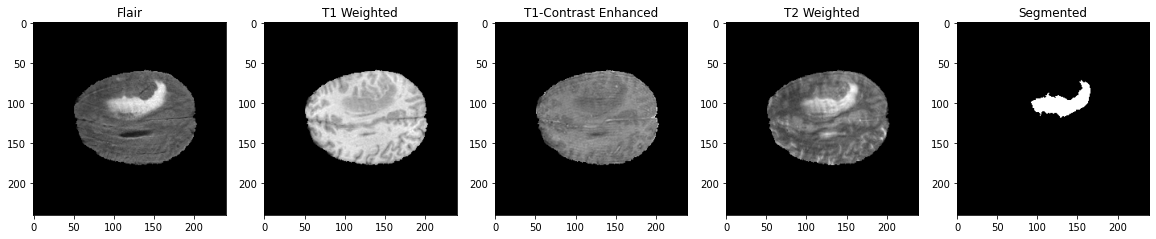

In [8]:
#Akses Dataset dari GDrive
TRAIN_DATASET_PATH = '/content/drive/MyDrive/DATA WAREHOUSE/BRATs 2020/BraTS2020/BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '/content/drive/MyDrive/DATA WAREHOUSE/BRATs 2020/BraTS2020/BraTS2020_TrainingData/'

test_image_flair = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_T1 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_T1ce = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_T2 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_image_seg = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()

slice_w = 20

fic, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize = (20, 10))
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap='gray')
ax1.set_title('Flair')
ax2.imshow(test_image_T1[:,:,test_image_flair.shape[0]//2-slice_w], cmap='gray')
ax2.set_title('T1 Weighted')
ax3.imshow(test_image_T1ce[:,:,test_image_flair.shape[0]//2-slice_w], cmap='gray')
ax3.set_title('T1-Contrast Enhanced')
ax4.imshow(test_image_T2[:,:,test_image_flair.shape[0]//2-slice_w], cmap='gray')
ax4.set_title('T2 Weighted')
ax5.imshow(test_image_seg[:,:,test_image_flair.shape[0]//2-slice_w], cmap='gray')
ax5.set_title('Segmented')

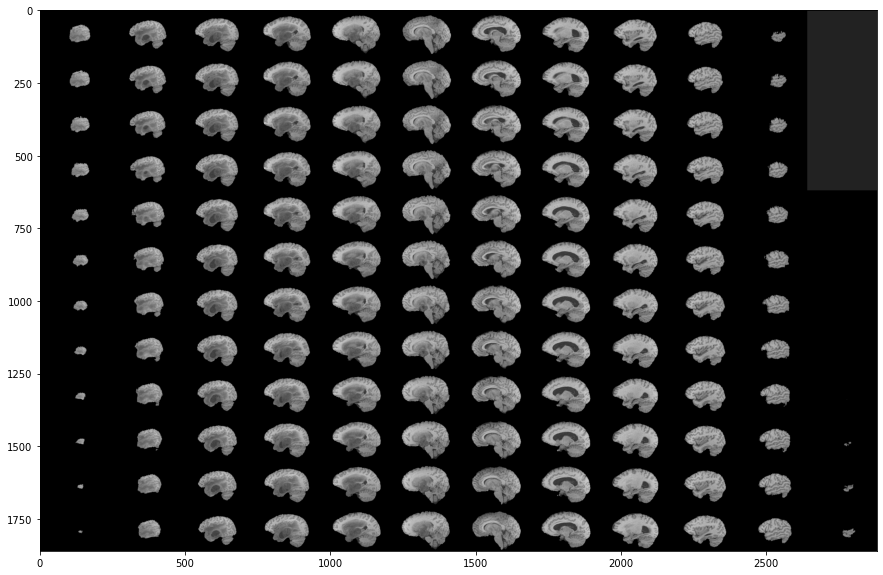

In [9]:
#Visualisasi tiap slice dataset nifti

fig, ax1 = plt.subplots(1, 1, figsize=(15,15))
ax1.imshow(rotate(montage(test_image_T1[50:-50,:,:]), 90, resize=True), cmap='gray')

# Build Model

## UNet model

In [10]:
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)

## UBNetSeg Model

In [11]:
def build_UBNetSeg(inputs, ker_init, dropout):
    conv1 = Conv2D(16, 7, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(16, 7, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, 5, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(32, 5, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    #conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool3)
    conv4 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv4)
    #pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv4)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv6)

    up7 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3, up7], axis = 3)
    
    conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    #conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2, up8], axis = 3)
    conv8 = Conv2D(32, 5, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(32, 5, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1, up9], axis = 3)
    conv9 = Conv2D(16, 7, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(16, 7, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv9)
    
    return Model(inputs = inputs, outputs = conv10)

## Evaluation and Compile 

In [12]:
# Fungsi menghitung precision, sensitivity, dan specificity
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [13]:
#Fungsi menghitung dice coefficient keseluruhan
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

In [14]:
#Compile Model

#ukuran citra
IMG_SIZE = 128
input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

model = build_unet(input_layer, 'he_normal', 0.2)
model.compile(loss = "categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy', tf.keras.metrics.MeanIoU(num_classes=4),
                        dice_coef,
                        precision,
                        sensitivity,
                        specificity]
             )

In [15]:
#Plot model yang digunakan

'''
plot_model(model, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)
'''

"\nplot_model(model, \n           show_shapes = True,\n           show_dtype=False,\n           show_layer_names = True, \n           rankdir = 'TB', \n           expand_nested = False, \n           dpi = 70)\n"

## Load Data

In [16]:
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 

In [17]:
train_ids[:10]

['BraTS20_Training_212',
 'BraTS20_Training_167',
 'BraTS20_Training_013',
 'BraTS20_Training_232',
 'BraTS20_Training_334',
 'BraTS20_Training_293',
 'BraTS20_Training_361',
 'BraTS20_Training_106',
 'BraTS20_Training_006',
 'BraTS20_Training_287']

In [18]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))

        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
                    
        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y
        
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

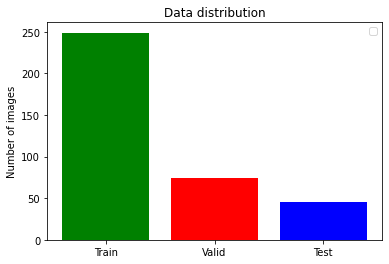

In [19]:
# show number of data for each dir 
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()
    
showDataLayout()

In [20]:
csv_logger = CSVLogger('/content/training_UNet.log', separator=',', append=False)


callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                      factor=0.2,
                                      patience=2, 
                                      min_lr=0.000001, 
                                      verbose=1),
    csv_logger]

## Training Model

In [22]:
K.clear_session()

history =  model.fit(training_generator,
                    epochs=50,
                    steps_per_epoch=len(train_ids),
                    callbacks= callbacks,
                    validation_data = valid_generator)

249/249 [==============================] - 1822s 7s/step - loss: 0.1132 - accuracy: 0.9836 - mean_io_u: 0.5224 - dice_coef: 0.2643 - precision: 0.9815 - sensitivity: 0.9676 - specificity: 0.9946 - val_loss: 0.0769 - val_accuracy: 0.9815 - val_mean_io_u: 0.6694 - val_dice_coef: 0.2685 - val_precision: 0.9815 - val_sensitivity: 0.9815 - val_specificity: 0.9938 - lr: 0.0010


In [23]:
model.save("/content/model_UBNetSeg_3DMRI.h5")

In [25]:
model = keras.models.load_model('/content/model_UBNetSeg_3DMRI.h5',
                                custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity
                                                  },
                                compile=False)

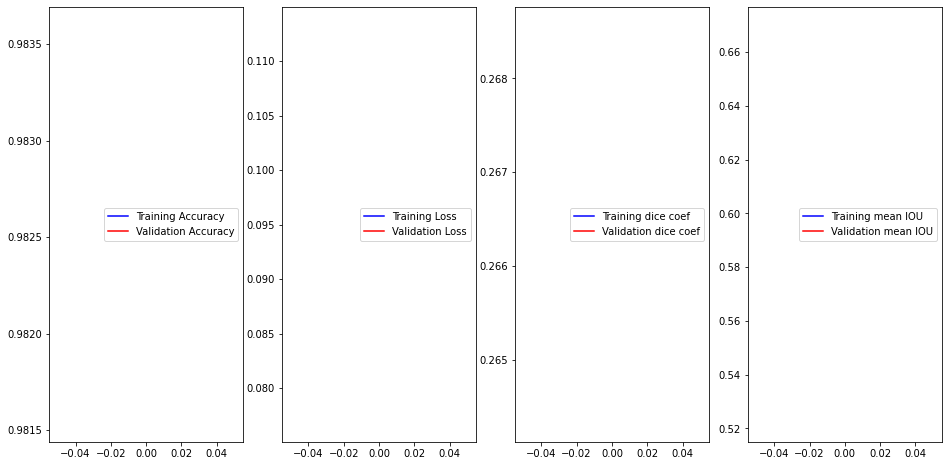

In [26]:
history = pd.read_csv('/content/training_UNet.log', sep=',', engine='python')
hist=history


acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

iou = hist['mean_io_u']
val_iou = hist['val_mean_io_u']


f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,iou,'b',label='Training mean IOU')
ax[3].plot(epoch,val_iou,'r',label='Validation mean IOU')
ax[3].legend()

plt.show()

In [27]:
hist.head()

,epoch,accuracy,dice_coef,loss,lr,mean_io_u,precision,sensitivity,specificity,val_accuracy,val_dice_coef,val_loss,val_mean_io_u,val_precision,val_sensitivity,val_specificity
0,0,0.98359,0.264337,0.113168,0.001,0.522372,0.98154,0.967582,0.994558,0.981542,0.26855,0.076883,0.669433,0.981485,0.981514,0.993839
